# Foundations of Logistic Regression

In [43]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [44]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [45]:
p = 0.3
sample_size = 100
samples = bernoulli.rvs(p, size=sample_size)

#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

(array([76.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

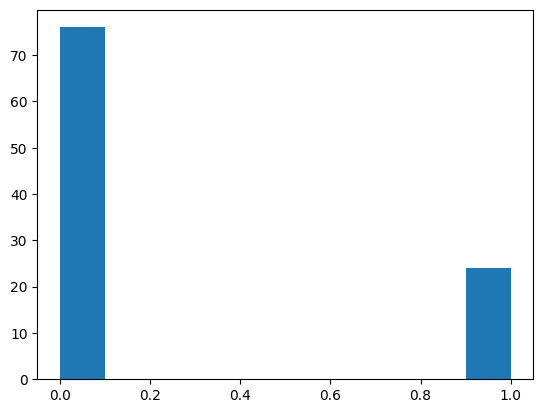

In [46]:
plt.hist(samples)

#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [47]:
# Averaging the outcomes will give me the most likelihood estimate.
mle = np.average(samples)
print(F"p is estimated at {mle}")

p is estimated at 0.24


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: The estimate is based on a sample of stochastic outcomes rather than deterministic outcomes. By random chance, we could have ended up with a different distribution than the "most likely one" given the true probability parameter. Example: a hundred coin tosses can give us more tails than head just by chance, even if the chance is 50/50 for both. 

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

In [48]:
# We'll simulate 100 outcomes (the size of our empirical sample)
# using our most likelihood estimate p_estimate.
# The average of the simulation gives us a new simulated probability.
# Doing it a 1000 times gives us the posterior distribution.
# Our simulation gives us values that fall well between 0 and 1 so we can just
# use a normal distribution for this.

ep_simulation_n = 1000

empirical_posterior = [
    np.average(bernoulli.rvs(mle, size=sample_size)) 
    for _ in range(0, ep_simulation_n)
]

empirical_posterior_mean = (mle * (1 - mle)) / ep_simulation_n
empirical_posterior = 

(array([  5.,  55., 153., 251., 244., 199.,  61.,  25.,   6.,   1.]),
 array([0.12 , 0.149, 0.178, 0.207, 0.236, 0.265, 0.294, 0.323, 0.352,
        0.381, 0.41 ]),
 <BarContainer object of 10 artists>)

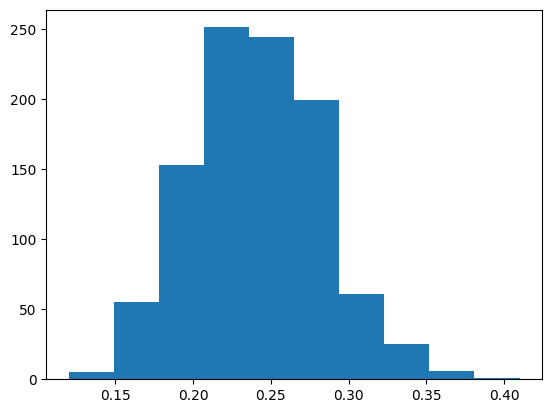

In [49]:
plt.hist(empirical_posterior)

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

(array([771.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 229.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

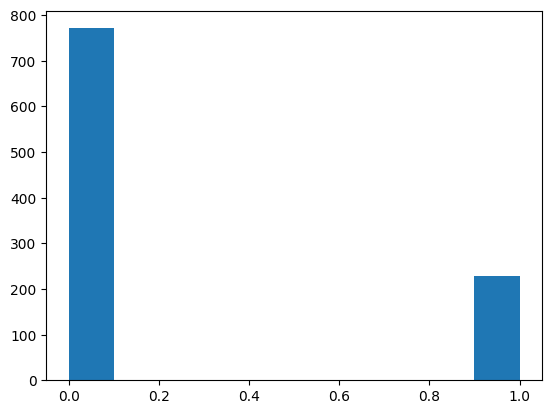

In [50]:
# Here we use the posterior predictive distribution of y 
# to generate new samples for a hypothetical unobserved student

# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
for pi in empirical_posterior:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

plt.hist(post_pred_sims)

# There is a higher probability that the outcome of y = 0, which means that
# a given individual taken at random from this sample is more likely not to
# be a right-of-centre voter. Thus I would classify them as
# "not a right-of-centre voter".

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a) Load the ANES 2020 sample, and check the number of respondents. (Hint: it's a `stata` file)

In [51]:
# Load ANES data
df = pd.read_stata("anes_timeseries_2020_stata_20210324.dta")

# Check dataset size
print(df.shape)


(8280, 1381)


#### b) Subset the dataset to include only people who `intend to vote for president` in the pre-election study (Hint: in the codebook look for variable `V201032`)

In [52]:
# Focus on voters only 
# Turnout Intention variable: V201032
print(df['V201032'].value_counts())

df = df[df['V201032'] == "1. Yes"]

V201032
1. Yes              7272
2. No                570
-1. Inapplicable     415
-9. Refused           13
-8. Don't know        10
Name: count, dtype: int64


#### c) Define the outcome of interest as 1 if the voter will vote for the Republicans, 0 otherwise. (Hint: in the codebook look for variable `V201033` )

In [53]:
print(df['V201033'].value_counts())

V201033
1. Joe Biden                    3759
2. Donald Trump                 3016
5. Other candidate {SPECIFY}     175
3. Jo Jorgensen                  133
-9. Refused                      101
4. Howie Hawkins                  55
-8. Don't know                    33
-1. Inapplicable                   0
Name: count, dtype: int64


In [54]:
Y = pd.Series(df['V201033'] == "2. Donald Trump").astype(int)
Y

0       1
1       0
2       0
3       0
4       1
       ..
8274    1
8275    1
8276    1
8277    0
8279    0
Name: V201033, Length: 7272, dtype: int64

#### d) Create a design matrix including age, sex, education or anything else you think would be a good predictor of the vote. # Turn these features into a numeric matrix so we can use them to fit the model. 

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [61]:
# Age: 
age_num = pd.to_numeric(df['V201507x'], errors='coerce')

# College Degree or Higher:
def is_college_plus(entry):
    if entry == "4. Associate degree in college - occupational/vocational":
        return 1
    if entry == "5. Associate degree in college - academic":
        return 1
    if entry == "6. Bachelor’s degree (e.g. BA, AB, BS)":
        return 1
    if entry == "7. Master’s degree (e.g. MA, MS, MEng, MEd, MSW, MBA)":
        return 1
    if entry == "8. Professional school degree (e.g. MD, DDS, DVM, LLB, JD)/Doctoral degree (e.g. PHD, EDD)":
        return 1
    return 0
    
college_edu = pd.Series(
    [is_college_plus(entry) for entry in df['V201510']]
)

# Sex:
male_binary = pd.Series(df['V201600'] == "1. Male").astype(int)

# Ethnicity: 
white_binary = pd.Series(df['V201549x'] == "1. White, non-Hispanic").astype(int)

# Create design matrix 
X = pd.DataFrame({
    'Age': age_num,
    'College_Degree_or_Higher': college_edu,
    'Sex_Male': male_binary,
    'Ethnicity_White': white_binary
})


# Display the first few rows of the DataFrame
print(X.head())

    Age  College_Degree_or_Higher  Sex_Male  Ethnicity_White
0  46.0                       0.0       1.0              0.0
1  37.0                       0.0       0.0              0.0
2  40.0                       0.0       0.0              1.0
3  41.0                       1.0       1.0              0.0
4  72.0                       0.0       1.0              0.0


#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [62]:
YX = pd.concat([Y, X], axis=1)
YX = YX.dropna()

# Examine the correlation between covariates and outcome (outcome is the first column)
# Can you identify some `perfect multicollinearity' that could hinder the estimation ? 
np.corrcoef(YX.T)

array([[ 1.        ,  0.10319669, -0.01786517,  0.07873625,  0.21892951],
       [ 0.10319669,  1.        , -0.00355751,  0.01635872,  0.16034236],
       [-0.01786517, -0.00355751,  1.        ,  0.02153104,  0.00757093],
       [ 0.07873625,  0.01635872,  0.02153104,  1.        ,  0.02111062],
       [ 0.21892951,  0.16034236,  0.00757093,  0.02111062,  1.        ]])

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [93]:
Y = YX.iloc[:,0]
X = pd.DataFrame(YX.iloc[:,1:], columns=['Age', 'College_Degree_or_Higher', 'Sex_Male', 'Ethnicity_White'])# Design matrix with column names
X_with_intercept = sm.add_constant(X)
model = sm.Logit(Y, X_with_intercept).fit()
model.params

Optimization terminated successfully.
         Current function value: 0.646879
         Iterations 5


const                      -1.746284
Age                         0.009187
College_Degree_or_Higher   -0.131390
Sex_Male                    0.317783
Ethnicity_White             1.045700
dtype: float64

#### g) Get summary of regression output.

In [94]:
# Get summary results
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                V201033   No. Observations:                 5824
Model:                          Logit   Df Residuals:                     5819
Method:                           MLE   Df Model:                            4
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                 0.04535
Time:                        16:25:40   Log-Likelihood:                -3767.4
converged:                       True   LL-Null:                       -3946.4
Covariance Type:            nonrobust   LLR p-value:                 3.378e-76
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.7463      0.106    -16.542      0.000      -1.953      -1.539
Age                          0.0092      0.002      5.319      0.000       0.006       0.013
College_Degree_or_Higher    -0.1314      0.081     -1.625      0.104      -0.290       0.027
Sex_Male                     0.3178      0.055      5.778      0.000       0.210       0.426
Ethnicity_White              1.0457      0.068     15.385      0.000       0.912       1.179
============================================================================================
"""

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [ ]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

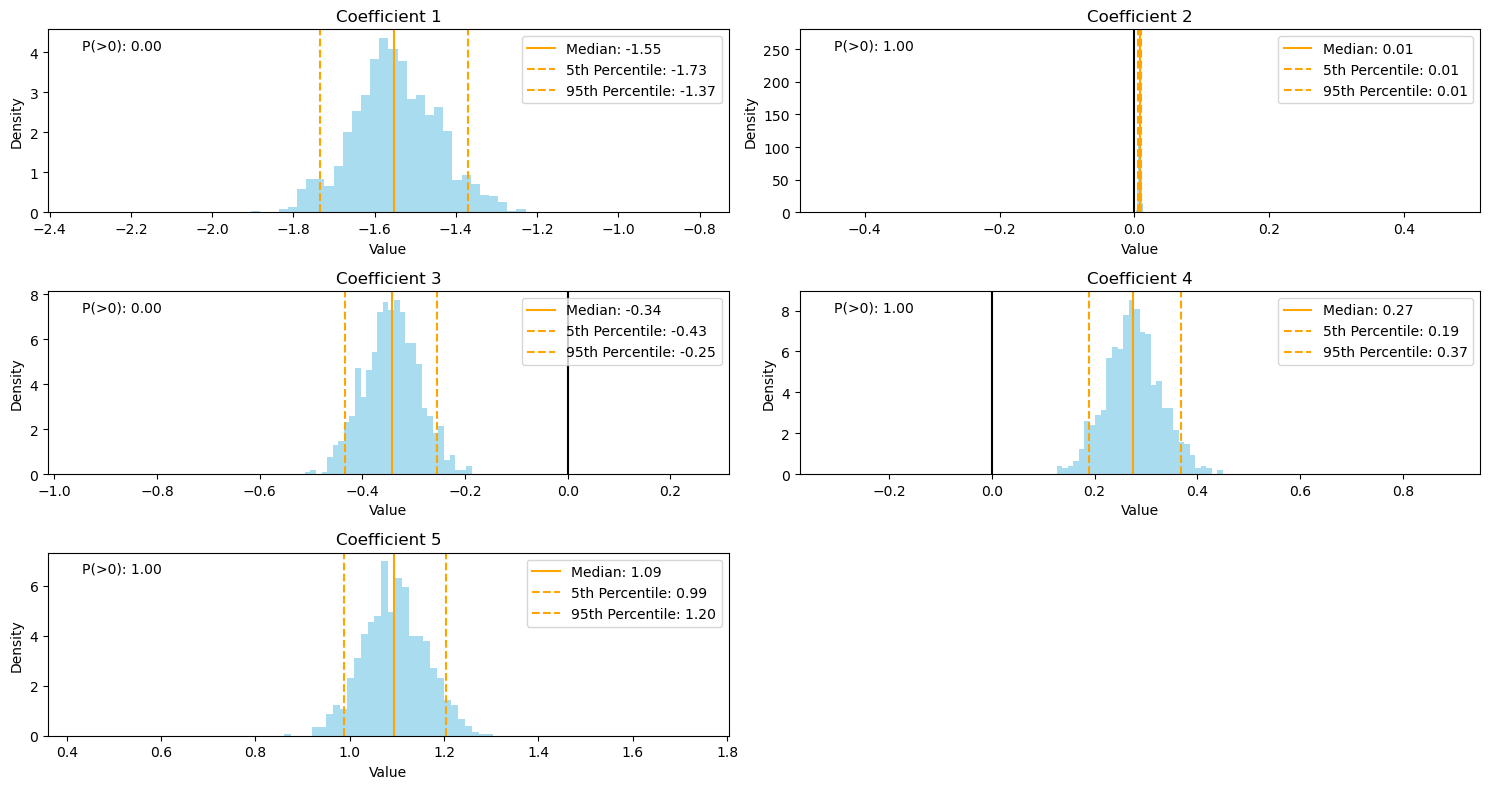

In [ ]:
...

#### i) Now let's practice making predictions from this model that we learned. Below is definded the `average american voter`. For this hypothetical person, make a prediction for the probability of voting republican. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [ ]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(...)

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times who they will vote for). Who does the average american voter turn to in 2020

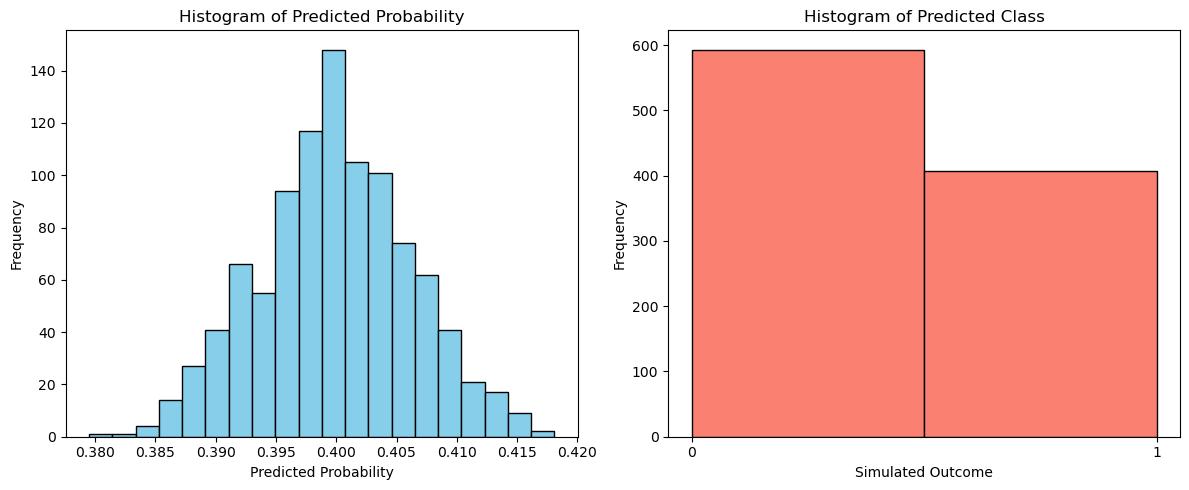

In [ ]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = ...

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
